**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 6.2 MB/s 
     |████████████████████████████████| 743 kB 66.6 MB/s 
     |████████████████████████████████| 4.9 MB 7.3 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=9d32124b9d554ffe46be1f5731c40c9b19c116c77fb80659054dd57ce7824b36
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=1825fbbe5a5a0c9773f06e9fd3335b5f7dae9bf16283c90f9b710e1a799f0c5e
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'  #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url) #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 

In [ ]:
data = '/content/drive/MyDrive/BADS7105/Voice/Wongnai Reviews - Small.csv'
df = pd.read_csv(data)

In [ ]:
df.head(30)

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...
5,6,เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญ เลยก็ว่าได้ ...
6,7,สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาว Wongna...
7,8,Starbucks \nเกี่ยวกับร้าน: \nร้าน Starbucks นี...
8,9,\nร้านเบอเกอรี่ร้านนี้อยู่ในร้านล้างรถชื่อว่า ...
9,10,ร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมน\nเป็นร้...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=15,n_components=200)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

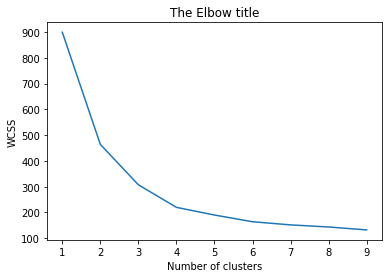

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','ทาน','กิน',"ผม","ฉัน","บ้าน","ซอย","อาหาร","กก","รีวิว", "(", ")", "ไหม","นขา",'น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","กวงทะเลเผา","เบเกอรี่","ชานม","คาปูชิโน่","อเมซอน","ไม่ชอบ","ชานม","Dakasi","วโรชา","ยี่ห้อ","ตลาดหนองมน",""}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 22), (กาแฟ, 18), (ชอบ, 6), (น่ารัก..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวงทะเลเผา, อาหารทะเล, เค้า, สด, เนื้อ, ปู, ห...","[(ร้านอาหาร, 12), (อร่อย, 8), (ส้มตำ, 5), (ราค..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ไข่มุก, 14), (ชานม, 11), (ชา, 6), (เครื่องดื..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(อร่อย, 7), (กาแฟ, 6), (ร้านกาแฟ, 5), (ชอบ, 5..."


In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 18), ('ชอบ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('ชั้น', 5), ('คน', 4), ('นึง', 4), ('วัง', 4)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 12), ('อร่อย', 8), ('ส้มตำ', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3)]

Cluster ID : 2

Most common words include : [('ไข่มุก', 14), ('ชานม', 11), ('ชา', 6), ('เครื่องดื่ม', 4), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('นม', 3), ('ไต้หวัน', 3), ('แวะ', 2)]

Cluster ID : 3

Most common words include : [('อร่อย', 7), ('กาแฟ', 6), ('ร้านกาแฟ', 5), ('ชอบ', 5), ('บอ', 4), ('พาย', 4), ('ซื้อ', 4), ('มีโอกาส', 3), ('ถนน', 3), ('จ', 3)]



**Step 4 - result discussion**

Cluster ID : 0 (Coffee holic): นักดื่มกาแฟตัวยง มีไลฟ์สไตล์ในการดื่นกาแฟพร้อมเบอร์เกอรี่ง่ายๆ ก่อนทำงาน  เน้นรีวิวร้านกาแฟที่หาได้ตามห้างสรรพสินค้าทั่วไป

Cluster ID : 1 (Taster): กลุ่มนักชิมอาหารจากหลากหลายสถานที่ โดยเฉพาะอาหารไทย ค่อนข้างให้ความเห็นในเชิงบวก และเล่าความประทับใจเพื่อเชิญชวนให้ไปรับประทาน 


Cluster ID : 2 (Teaholic): กลุ่มคนหลงรักการดื่มชาโดยเฉพาะชานมไข่มุก ท่ามหกลางบรรยากาศ สบายๆ พร้อมเดิมชิมอาหารประเภทสตรีทฟู้ด

Cluster ID : 3 (Variety): กลุ่มคนรับประทานอาหารหลากหลาย ไม่ว่าจะเป็นอาหารเวียดนาม กาแฟเจ้าดัง ไอครีม ร้านไหนที่ว่าดี ต้องมีบุคคลกลุ่มเข้าไปเยื่อน 


